# Data Science
- Student: Dmytro Geleshko
- Group: IP-91
- Var: 6

# Imports

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import tensorflow as tf

# Config

In [17]:
# var 6
np.random.seed(6)
plt.rcParams["figure.figsize"] = (20, 8)
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.3f}".format

# Load saved coef

In [18]:
features = ["volume_norm", "log_close", "month_sin", "month_cos", "year_sin", "year_cos"]

vol_mean_std = np.load("saved_params/volume_mean_std.npy")
vol_mean, vol_std = vol_mean_std
vol_mean, vol_std

(182627.71029163653, 270991.2462469771)

# Data

## Load last data from internet

In [19]:
url = "https://www.investing.com/crypto/bitcoin/btc-usd-historical-data"

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)

dfs = pd.read_html(r.text, attrs = {"id": "curr_table"}, index_col="Date", parse_dates=True)[0]
dfs.columns = dfs.columns.map(lambda x: str.lower(x))

# drop & rename columns
dfs.drop(columns=["open", "high", "low", "change %"], inplace=True)
dfs.rename(columns={"price":"close", "vol.":"volume"}, inplace=True)
dfs.index.name="date"

# sort index and get newest data
dfs.sort_index(inplace=True)
dfs = dfs[-24:]
dfs

,close,volume
date,,
2021-11-15,"63,562.000",5.27K
2021-11-16,"60,124.000",13.07K
2021-11-17,"60,386.100",6.72K
2021-11-18,"57,014.000",11.54K
2021-11-19,"58,130.000",5.18K
2021-11-20,"59,739.000",3.13K
2021-11-21,"58,790.000",2.44K
2021-11-22,"56,299.000",8.83K
2021-11-23,"57,602.000",8.56K


## Transfrom volume

In [20]:
_vol = np.ones((dfs.shape[0]), dtype=float)
for i, vol in enumerate(dfs["volume"]):
    coef = 1
    if vol == "-":
        vol = "0"
    elif "K" in vol:
        coef = 1000
        vol = vol.replace("K", "")
    elif "M" in vol:
        coef = 1000000
        vol = vol.replace("M", "")
    _vol[i] = float(vol) * coef
    
dfs["volume"] = _vol.astype(np.float32)
dfs

,close,volume
date,,
2021-11-15,"63,562.000","5,270.000"
2021-11-16,"60,124.000","13,070.000"
2021-11-17,"60,386.100","6,720.000"
2021-11-18,"57,014.000","11,540.000"
2021-11-19,"58,130.000","5,180.000"
2021-11-20,"59,739.000","3,130.000"
2021-11-21,"58,790.000","2,440.000"
2021-11-22,"56,299.000","8,830.000"
2021-11-23,"57,602.000","8,560.000"


## Normalize values

In [21]:
dfs["volume"] = np.clip(dfs["volume"], 0, 1000000)
dfs["volume_norm"] = (dfs["volume"] - vol_mean) / vol_std

# find log close
dfs["log_close"] = np.log(dfs["close"].values)
dfs

,close,volume,volume_norm,log_close
date,,,,
2021-11-15,"63,562.000","5,270.000",-0.654,11.060
2021-11-16,"60,124.000","13,070.000",-0.626,11.004
2021-11-17,"60,386.100","6,720.000",-0.649,11.009
2021-11-18,"57,014.000","11,540.000",-0.631,10.951
2021-11-19,"58,130.000","5,180.000",-0.655,10.970
2021-11-20,"59,739.000","3,130.000",-0.662,10.998
2021-11-21,"58,790.000","2,440.000",-0.665,10.982
2021-11-22,"56,299.000","8,830.000",-0.641,10.938
2021-11-23,"57,602.000","8,560.000",-0.642,10.961


## Adding time features

In [22]:
# add time features
day = 24*60*60
year = (365.2425)*day
month = year/12
timestamp_s = dfs.index.map(pd.Timestamp.timestamp)
dfs["month_sin"] = np.sin(timestamp_s * (2 * np.pi / month))
dfs["month_cos"] = np.cos(timestamp_s * (2 * np.pi / month))
dfs["year_sin"] = np.sin(timestamp_s * (2 * np.pi / year))
dfs["year_cos"] = np.cos(timestamp_s * (2 * np.pi / year))
dfs

,close,volume,volume_norm,log_close,month_sin,month_cos,year_sin,year_cos
date,,,,,,,,
2021-11-15,"63,562.000","5,270.000",-0.654,11.060,0.196,-0.981,-0.719,0.695
2021-11-16,"60,124.000","13,070.000",-0.626,11.004,-0.009,-1.000,-0.707,0.708
2021-11-17,"60,386.100","6,720.000",-0.649,11.009,-0.214,-0.977,-0.694,0.720
2021-11-18,"57,014.000","11,540.000",-0.631,10.951,-0.410,-0.912,-0.682,0.732
2021-11-19,"58,130.000","5,180.000",-0.655,10.970,-0.588,-0.809,-0.669,0.743
2021-11-20,"59,739.000","3,130.000",-0.662,10.998,-0.741,-0.671,-0.656,0.755
2021-11-21,"58,790.000","2,440.000",-0.665,10.982,-0.863,-0.505,-0.643,0.766
2021-11-22,"56,299.000","8,830.000",-0.641,10.938,-0.948,-0.317,-0.630,0.777
2021-11-23,"57,602.000","8,560.000",-0.642,10.961,-0.993,-0.116,-0.616,0.787


## Cast to float32

In [23]:
dfs = dfs.astype({
    "close":np.float32,
    "volume":np.float32,
    "volume_norm":np.float32,
    "log_close":np.float32,
    "month_sin":np.float32,
    "month_cos":np.float32,
    "year_sin":np.float32,
    "year_cos":np.float32})
dfs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2021-11-15 to 2021-12-08
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close        24 non-null     float32
 1   volume       24 non-null     float32
 2   volume_norm  24 non-null     float32
 3   log_close    24 non-null     float32
 4   month_sin    24 non-null     float32
 5   month_cos    24 non-null     float32
 6   year_sin     24 non-null     float32
 7   year_cos     24 non-null     float32
dtypes: float32(8)
memory usage: 960.0 bytes


# Load Models

## LSTM Neural Network

In [24]:
model_lstm = tf.keras.models.load_model("saved_model/v1_lstm.h5")

model_lstm.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 21, 6)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 42)                8232      
                                                                 
 dense_3 (Dense)             (None, 3)                 129       
                                                                 
Total params: 8,361
Trainable params: 8,361
Non-trainable params: 0
_________________________________________________________________


## Stat model

In [25]:
model_linear = tf.keras.models.load_model("saved_model/v1_linear.h5")

model_linear.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 21, 6)]           0         
                                                                 
 reshape_3 (Reshape)         (None, 126)               0         
                                                                 
 dense_4 (Dense)             (None, 3)                 381       
                                                                 
Total params: 381
Trainable params: 381
Non-trainable params: 0
_________________________________________________________________


# Prediction

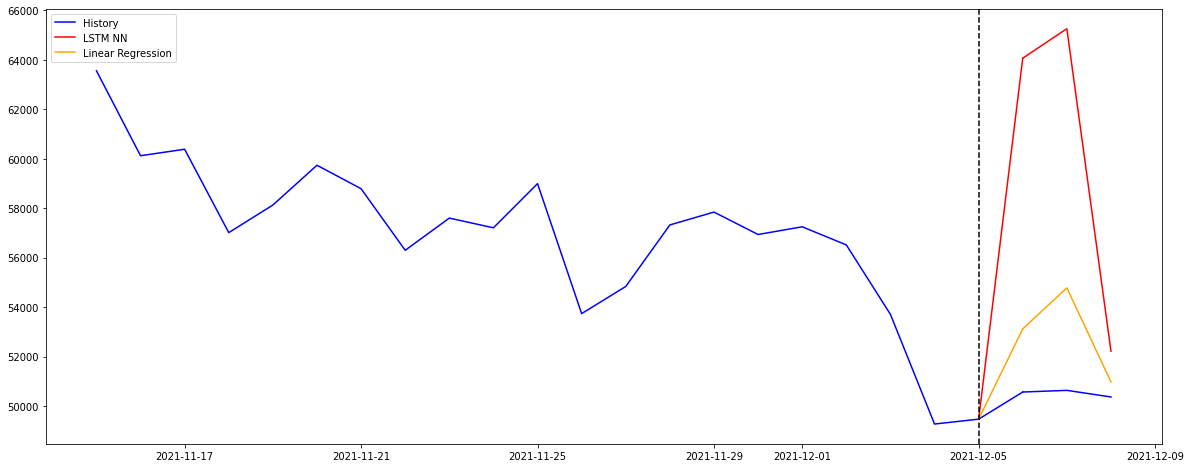

In [40]:
x = dfs[features].iloc[-24:-3].values.reshape((1, 21, 6))

y = dfs["close"].iloc[-3:]
y_hat_nn = model_lstm.predict(x)[0]
y_hat_stat = model_linear.predict(x)[0]

# convert X
x = dfs["close"].iloc[-24:-3]
    
# convert y def 
y_hat_nn = np.exp(y_hat_nn)
y_hat_stat = np.exp(y_hat_stat)

# dates
dates_x = pd.date_range(dfs.index[-24], periods=24, freq="D")
dates_y = dates_x[-3:]
dates_x = dates_x[:-3]

#plot real
plt.plot(dates_x, x, label="History", color="blue")
plt.plot(dates_y, y, color="blue")
plt.plot([dates_x[-1], dates_y[0]], [x[-1], y[0]], color="blue")

# plot nn forecast
plt.plot(dates_y, y_hat_nn, label="LSTM NN", color="red")
plt.plot([dates_x[-1], dates_y[0]], [x[-1], y_hat_nn[0]], color="red")

# plot stat forecast
plt.plot(dates_y, y_hat_stat, label="Linear Regression", color="orange")
plt.plot([dates_x[-1], dates_y[0]], [x[-1], y_hat_stat[0]], color="orange")

plt.axvline(dates_x[-1], color="black", linestyle="--")

plt.legend()
plt.show()